In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from utils.mag_scripts import * 
from utils.barplots import * 


import altair as alt


# supress warnings
import warnings
warnings.filterwarnings('ignore')

How does high-fat diet impact the microbiome of mice?
=====================================================

![Picture of obese mice](https://upload.wikimedia.org/wikipedia/commons/0/0b/Fatmouse.jpg)

In [2]:
#go to output folder
%cd ../Example/

/home/animeshs/promec/GD/Tutorial/Example


In [3]:
# load metadata
metadata= pd.read_table('metadata.txt',index_col=0)
metadata.head()

,Age,Air_temperature,Diet,Food_name,Country,Provider,Sex,Strain,Body_weight
ERR675518,17.0,30.0,chow,D12450B,Norway,Taconic in Denmark,male,C57/BL6,25.62
ERR675519,17.0,30.0,HF,D12492,Norway,Taconic in Denmark,male,C57/BL6,30.15
ERR675520,17.0,30.0,chow,D12450B,Norway,Taconic in Denmark,male,C57/BL6,26.61
ERR675521,17.0,30.0,HF,D12492,Norway,Taconic in Denmark,male,C57/BL6,28.29
ERR675522,17.0,30.0,chow,D12450B,Norway,Taconic in Denmark,male,C57/BL6,26.49


We confirm that the mice on high-fat diet put really more weight on.

<AxesSubplot:xlabel='Diet', ylabel='Body_weight'>

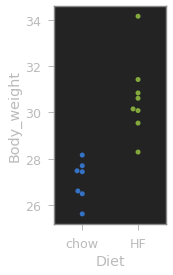

In [4]:
f= plt.figure(figsize=(2,4))
sns.swarmplot(y='Body_weight',x='Diet',data=metadata)

In [19]:
# create a short label for each genome
Tax= pd.read_table('Results/taxonomy.tsv',index_col=0)
Labels=Tax.ffill(axis=1).species.copy()
Labels.loc[Tax.species.isnull()]+= ' '+ Labels.index[Tax.species.isnull()]


## Relative abundance


For the relative abundance, we take the coverage over the genome, not the raw counts. This implicitly normalizes for genome size. The coverage is calculated as the median of the coverage values calculated in 1kb blocks.

In [6]:
D = pd.read_table("Results/counts/median_coverage_genomes.tsv",index_col=0)

In [7]:
#calculate relative abundance

relab = (D.T/D.sum(1)).T

### Bar chart wich group labels

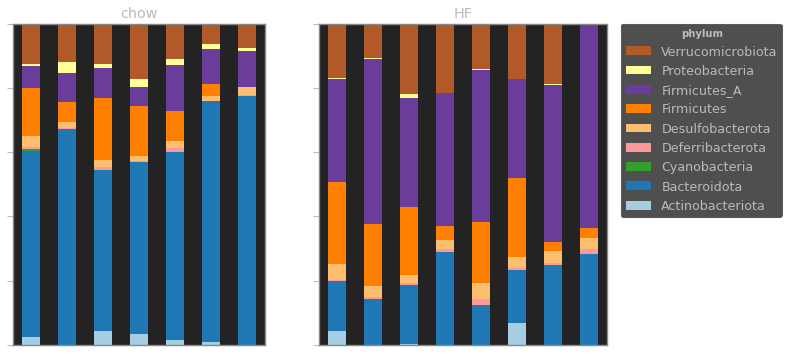

In [8]:

level='phylum'



grouped_data =  relab.groupby(Tax[level],axis=1).sum()*100
filtered_data = filter_taxa( grouped_data,  topN=10)



axe=Grouped_Bar_Plot(filtered_data,metadata.Diet,figsize=(11,5),order=['chow','HF'])

axe[1].legend_.set_title(level,{'weight':'bold'})


## Compositional data analysis 


In order to analyze the microbiome at the species or genome-level we use compositional data analysis (CoDa), see more on [Wikipedia](https://en.wikipedia.org/wiki/Compositional_data) and this article:

>Gloor, Gregory B., Jean M. Macklaim, Vera Pawlowsky-Glahn, and Juan J. Egozcue. 2017. “Microbiome Datasets Are  Compositional: And This Is Not Optional.” Frontiers in Microbiology 8 (November). Frontiers: 2224. 
    doi: [10.3389/fmicb.2017.02224](https://www.frontiersin.org/articles/10.3389/fmicb.2017.02224).


For this, we load the raw counts and use centric log-ratios (CLR) after imputing values for the zeros.

    


In [11]:
#load raw counts

Counts= pd.read_csv('Results/counts/raw_counts_genomes.tsv',index_col=0,sep='\t').T

# transforme counts with centrig log ratio

data= clr(Counts)

### PCA (PCoA) of the robust Aitchison distance

In [12]:

from sklearn.decomposition import PCA

pca= PCA()
transformed_data= pca.fit_transform(data)


<AxesSubplot:xlabel='PC 1', ylabel='PC 2'>

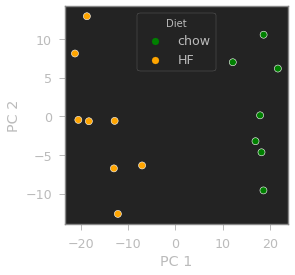

In [13]:
f= plt.figure(figsize=(4,4))
pca_data= pd.DataFrame()
pca_data['PC 1']= transformed_data[:,0]
pca_data['PC 2']= transformed_data[:,1]
pca_data.index= data.index


sns.set_palette(['green','orange'])
sns.scatterplot(x='PC 1',y='PC 2',data=pca_data,hue=metadata.Diet)




### Differencial abundance analyis

Ass the counts are normalized in centered log-ratio the log FC becomes the difference.

We use the welch test to assess differential abundance in the two groups. This is a simple version of aldex2. See Gloor et all for more information.

In [14]:


#man abundance per group
Stats= data.groupby(metadata.Diet).mean().T
Stats['Id']=Stats.index

#log Fold change. 
Stats['logFC']= Stats.HF-Stats.chow 

# 

from scipy.stats import ttest_ind

_,p= ttest_ind(data.loc[ metadata.query('Diet=="HF"').index ],
          data.loc[ metadata.query('Diet=="chow"').index ],
          equal_var=False
         )

Stats['Pvalue']= p

Stats['Pvalue_BH'] = correct_pvalues_for_multiple_testing(p)

Stats['logP']= -np.log10(Stats.Pvalue)
Stats['Name']= Labels


#### heatmap of significant Genomes



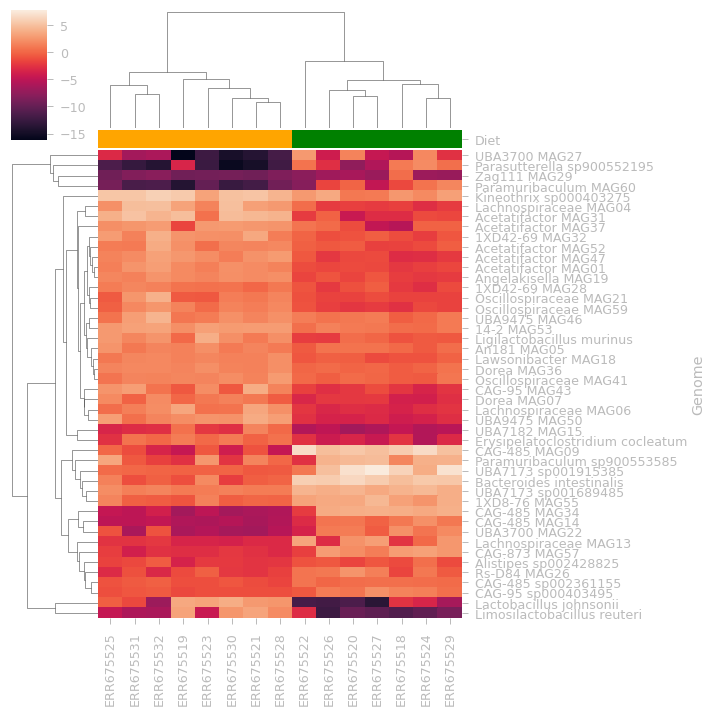

In [15]:
data.columns.name='Genome'
group_color=metadata.Diet.map({'HF':'orange','chow':'green'})

sig_data= data.T.loc[Stats.Pvalue_BH<0.1]

cmp=sns.clustermap(sig_data,
            row_cluster=True,
             yticklabels= Labels.loc[sig_data.index],
               col_colors= group_color,
              );



#### Vulcano plot

In [16]:

#non interactive plot
#sns.scatterplot(y='logP',x='logFC',data=Stats,hue='logP',palette='Reds')


xscale = alt.Scale(type='log')
chart=alt.Chart(Stats).mark_circle(opacity= 0.9).encode(
    y='logP',
    x=alt.X('logFC',title="Lean"+" "*30+"logFC"+" "*30+"Obese"),
    color=alt.Color('logP',scale=alt.Scale(scheme='reds')),
    tooltip=["Name",
        alt.Tooltip( "HF", type = "quantitative",format='.2f'),
        alt.Tooltip( "chow", type = "quantitative",format='.2f'),
             'Id'
    ]
)

chart.interactive()


alt.Chart(...)

kindom                    Bacteria
phylum                  Firmicutes
class                      Bacilli
order              Lactobacillales
family            Lactobacillaceae
genus                Lactobacillus
species    Lactobacillus johnsonii
Name: MAG08, dtype: object

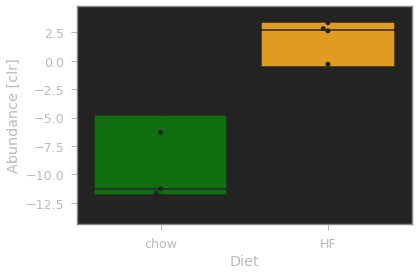

In [17]:

genome_of_interest= 'MAG08'

sns.boxplot(y=data[genome_of_interest],x=metadata.Diet)
sns.swarmplot(y=data[genome_of_interest],x=metadata.Diet,color='k')
plt.ylabel('Abundance [clr]')
Tax.loc[genome_of_interest]